# Import Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import os.path
import xgboost
import math
from sklearn.linear_model import LogisticRegression
from polylearn import FactorizationMachineClassifier
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, mean_squared_error #roc_auc_score as AUC
from sklearn.externals import joblib

n_bytes = 2**31
max_bytes = 2**31 - 1

def load_pickle(file_path):
    
    bytes_in = bytearray(0)
    input_size = os.path.getsize(file_path)
    with open(file_path, 'rb') as f_in:
        for _ in range(0, input_size, max_bytes):
            bytes_in += f_in.read(max_bytes)
    
    return pickle.loads(bytes_in)

In [2]:
train = load_pickle('train_df_after_preprocessing.pkl') # balanced class
valid = load_pickle('valid_df_after_preprocessing.pkl')
test = load_pickle('test_df_after_preprocessing.pkl')

train_click = train['click']
train_bidprice = train['bidprice']
train_payprice = train['payprice']
train_X = train.drop(['click', 'bidprice', 'payprice'], axis = 1)

valid_click = valid['click']
valid_bidprice = valid['bidprice']
valid_payprice = valid['payprice']
valid_X = valid.drop(['click', 'bidprice', 'payprice'], axis = 1)

# Model

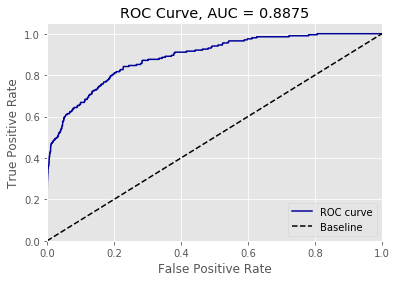

In [119]:
class CTR_Model():
    
    model_name = ""
    model = None
    FPR = None
    TPR = None
    AUC = None
    
    def __init__(self, name):
        self.model_name = name
        
    def saveModel(self):
        save_file = self.model_name + ".pickle.dat"
#         self.model = pickle.dump(self.model, open(save_file, "wb"))
        joblib.dump( self.model, save_file )
        
    def loadModel(self):
        read_file = self.model_name + ".pickle.dat"
        self.model = joblib.load(read_file)
        return self.model

    def train(self, train_X, train_click):
        if self.model_name == 'xgb':
            self.model = XGBClassifier(max_depth=5, learning_rate=0.15, 
                                        n_estimators=90, silent=True, 
                                        objective='binary:logistic', 
                                        booster='gbtree', n_jobs=1, nthread=None, 
                                        gamma=0, min_child_weight=1, 
                                        max_delta_step=0, subsample=1, 
                                        colsample_bytree=1, colsample_bylevel=1, 
                                        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
                                        base_score=0.5, random_state=0, seed=None, missing=None)
        elif self.model_name == 'lr':
            self.model = LogisticRegression()
        elif self.model_name == 'rf':
            self.model = RandomForestClassifier()
        elif self.model_name == 'fm':
            self.model = FactorizationMachineClassifier(max_iter = 800, random_state=666, loss = 'logistic')
            
        self.model.fit(train_X, train_click)
    
    def plotROC(self, true_labels, prediction_prob, plot = False):        
        fpr, tpr, _ = roc_curve(true_labels, prediction_prob, pos_label=1)
        AUC = "%.4f" % auc(fpr, tpr)
        self.FPR = fpr
        self.TPR = tpr
        self.AUC = AUC
        title = 'ROC Curve, AUC = '+str(AUC)

        with plt.style.context(('ggplot')):
            fig, ax = plt.subplots()
            ax.plot(fpr, tpr, "#000099", label='ROC curve')
            ax.plot([0, 1], [0, 1], 'k--', label='Baseline')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc='lower right')
            plt.title(title)
            

            
            
all_fpr, all_tpr, all_auc = [],[],[]

xgb = CTR_Model("xgb")
xgb.train(train_X, train_click)
prediction = xgb.model.predict_proba(valid_X)
xgb.plotROC(valid_click, prediction[:,1], plot=False)

In [120]:
xgb.saveModel()
model = joblib.load("xgb.pickle.dat")
model.predict_proba(valid_X)

array([[ 0.91311628,  0.0868837 ],
       [ 0.8868283 ,  0.11317171],
       [ 0.92955869,  0.07044129],
       ..., 
       [ 0.2975477 ,  0.7024523 ],
       [ 0.62738836,  0.37261167],
       [ 0.85059553,  0.14940447]], dtype=float32)